In [1]:
import torch
from torchvision import transforms
from dataset import NYUDataset
from custom_transforms import *
import plot_utils
import model_utils
from nn_model import Net

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%matplotlib inline
%load_ext nb_black
import torch.nn.functional as F

<IPython.core.display.Javascript object>

In [2]:
TRAIN = 0
bs = 8
sz = (320, 240)
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
mean, std = torch.tensor(mean), torch.tensor(std)
unnormalize = UnNormalizeImgBatch(mean, std)

tfms = transforms.Compose(
    [
        ResizeImgAndDepth(sz),
        RandomHorizontalFlip(),
        ImgAndDepthToTensor(),
        NormalizeImg(mean, std),
    ]
)

<IPython.core.display.Javascript object>

In [3]:
ds = NYUDataset("data/", tfms)
dl = torch.utils.data.DataLoader(ds, bs, shuffle=True)

<IPython.core.display.Javascript object>

In [4]:
xdl = torch.utils.data.DataLoader(ds, bs, shuffle=True)

<IPython.core.display.Javascript object>

In [5]:
ds[0][0].shape

torch.Size([3, 240, 320])

<IPython.core.display.Javascript object>

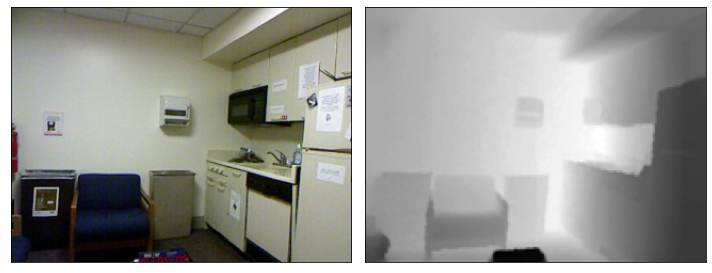

<IPython.core.display.Javascript object>

In [6]:
i = 1
plot_utils.plot_image(model_utils.get_unnormalized_ds_item(unnormalize, ds[i]))

# sample_batch = iter(dl).next()
# img, depth = sample_batch

In [7]:
model = Net()
model.to(device)

Net(
  (VGG): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

<IPython.core.display.Javascript object>

In [8]:
model.load_state_dict(torch.load("all-scales-trained.ckpt", map_location="cpu"))

<All keys matched successfully>

<IPython.core.display.Javascript object>

In [9]:
if TRAIN:
    model.train()
    n_epochs = 1
    lr = 0.0000005
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()), lr=lr
    )

    total_steps = 0
    for e in range(n_epochs):
        for batch, labels in dl:
            optimizer.zero_grad()

            batch = batch.to(device)
            labels = labels.to(device)

            preds = model(batch)
            loss = model_utils.depth_loss(preds, labels)

            loss.backward()
            optimizer.step()

            total_steps += 1

            model_utils.print_training_loss_summary(
                loss.item(), total_steps, e + 1, n_epochs, len(dl)
            )

<IPython.core.display.Javascript object>

In [10]:
if TRAIN:
    torch.save(model.state_dict(), "all-scales-trained.ckpt")

<IPython.core.display.Javascript object>

In [11]:
%%time
with torch.no_grad():
    model.eval()
    img, depth = iter(dl).next()
    preds = model(img.to(device))

CPU times: user 11.8 s, sys: 1.83 s, total: 13.7 s
Wall time: 25.9 s


<IPython.core.display.Javascript object>

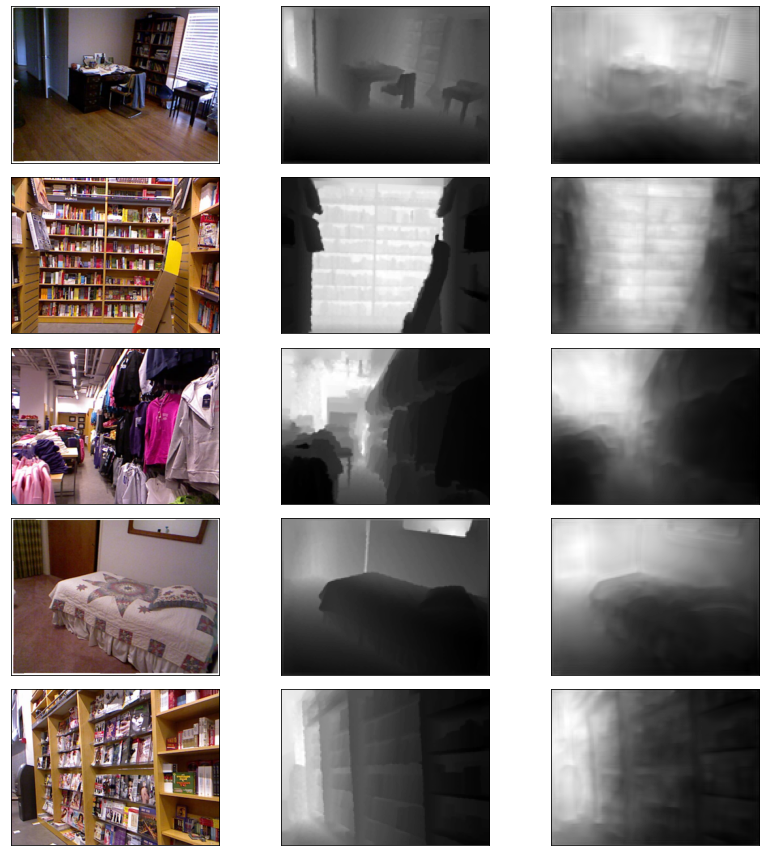

<IPython.core.display.Javascript object>

In [12]:
plot_utils.plot_model_predictions_on_sample_batch(
    images=unnormalize(img), depths=depth, preds=preds.squeeze(dim=1), plot_from=0
)

In [13]:
test_tfms = transforms.Compose(
    [
        transforms.Resize((240, 320)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)

<IPython.core.display.Javascript object>

In [14]:
import PIL
from PIL import Image

im = Image.open("imgs/img.jpg").rotate(180)
res = test_tfms(im)

model.eval()
pred = model(res[None].to(device))

<IPython.core.display.Javascript object>

In [15]:
pred_numpy_arr = pred.detach().squeeze(dim=1).squeeze(dim=0).cpu().numpy()
pred_numpy_arr = pred_numpy_arr - pred_numpy_arr.min()  # -0.660375
pred_numpy_arr = (
    pred_numpy_arr / pred_numpy_arr.max()
) * 255  # max = 2.1548061, brings scale to 0-255
pred_numpy_arr = pred_numpy_arr.astype("uint8")

<IPython.core.display.Javascript object>

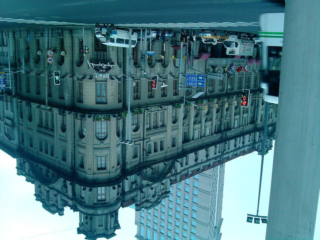

<IPython.core.display.Javascript object>

In [16]:
im.resize((320, 240), resample=PIL.Image.BILINEAR)

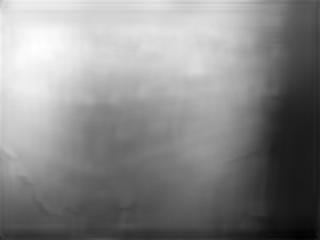

<IPython.core.display.Javascript object>

In [17]:
Image.fromarray(pred_numpy_arr, mode="L").resize((320, 240))

In [18]:
T, P = transforms.ToTensor(), transforms.ToPILImage()
dx, dy, g = model_utils.apply_sobel_operator_on_sample_ds_image(
    ds[10], unnormalize, T, P
)

<IPython.core.display.Javascript object>

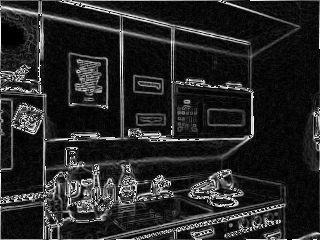

<IPython.core.display.Javascript object>

In [19]:
P(g)